In [31]:
!pip install COVID19Py
!pip install lmfit
!pip install covid-seird

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


## Simulation

We implement three models SIR, SEIR and SEIRD to predict confirmed cases and plot curves for susceptible, exposed, recovered and dead cases. We divide our implementation into three parts. The first part is data preparation. We utilize COVID19Py library to fetch global COVID\-19 data from Johns Hopkins University database. We store useful information i.e. confirmed cases, date and country population into data.json file. Users can select the model, define the country and set the number of prediction days. Our algorithm splits the total data into two parts. One part is for fitting the models and the other is for comparing with predicted data. The second part of our simulator is to fit the model. We define our model with differential equations and set initial parameters for $\alpha$, $\beta$,$\gamma$, $\delta$ and $\rho$. By passing fitting data to the chosen model, we update the parameters. The third part is the prediction part. We utilize the model with parameters obtained from the last step to make predictions for infected cases.



In [33]:
from typing import Dict
import COVID19Py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model, Parameters
from scipy.integrate import odeint
from scipy.stats import linregress

In [7]:
"""
Global Variables
"""
prediction_days = 100
country = "US"
modelName = "SEIRD"


In [8]:
def get_covid_data(code: str):
    CovidData = COVID19Py.COVID19(data_source="jhu")
    CovidDataForOneCountry = CovidData.getLocationByCountryCode(code.upper(), timelines=True)
#     print(CovidDataForOneCountry)

    timespan = 825
    # get date
    date = list(CovidDataForOneCountry[0]["timelines"]["confirmed"]["timeline"].keys())[-timespan:]
    # get confirmed cumulative cases
    confirmed_cumulative_cases = list(CovidDataForOneCountry[0]["timelines"]["confirmed"]["timeline"].values())[-timespan:]
    # get death cumulative cases
    death_cumulative_cases = list(CovidDataForOneCountry[0]["timelines"]["deaths"]["timeline"].values())[-timespan:]
    # get country population
    country_population = CovidDataForOneCountry[0]["country_population"]

    # generate dict to store covid data for one specific country
    CovidDataForOneCountryDict = {"date": date, "country_population": country_population, "confirmed": confirmed_cumulative_cases, "deaths": death_cumulative_cases}
#     print(CovidDataForOneCountryDict)

    import json
    # create json object from dictionary
    json = json.dumps(CovidDataForOneCountryDict)

    # open file for writing, "w" 
    f = open(str(country)+"_data.json","w")

    # write json object to file
    f.write(json)

    # close file
    f.close()


In [10]:
def get_fit_data():
  import json
  # Opening JSON file
  f = open(str(country)+"_data.json")

  # returns JSON object as a dictionary
  data = json.load(f);
  fit_days = len(data["date"]) - prediction_days
  # print(len(data["date"]))
  data["date"] = data["date"][0:fit_days];
  data["confirmed"] = data["confirmed"][0:fit_days];
  # print(len(data["date"]))
  # print(data)


  # Closing file
  f.close()


  # create json object from dictionary
  json = json.dumps(data)

  # open file for writing, "w"
  f = open("fit_"+str(country)+"_data.json","w")

  # write json object to file
  f.write(json)

  # close file
  f.close()

In [11]:
# Get and save data
get_covid_data(country);
get_fit_data();

In [14]:
"""
Disease Prediction Model
(SIR, SEIR, SEIRD)

S: number of susceptible people on day t
E: number of exposed people on day t
I: number of infected people on day t
R: number of recovered people on day t
D: number of dead people on day t

beta: expected amount of people an infected person infects per day
gamma: the proportion of infected recovering per day
ro: the total number of people an infected person infects 

"""



def model_we_use(x, r0, gamma, delta, alpha, rho, population, fit, initial_infected):
    def deriv(y, x, r0, gamma, delta, alpha, rho):
      beta = r0 * gamma
      if modelName == "SIR":
        S, I, R = y
        dSdt = -beta * S * I / population
        dIdt = beta * S* I / population - gamma * I
        dRdt = gamma * I
        return dSdt,  dIdt, dRdt
      elif modelName == "SEIR":
        S, E, I, R = y
        dSdt = -beta * S * I / population
        dEdt = beta * S* I / population - delta * E
        dIdt = delta * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

      elif modelName == "SEIRD":
        S, E, I, R, D = y
        dSdt = -beta * S * I / population
        dEdt = beta * S * I / population - delta * E
        dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
        dRdt = (1 - alpha) * gamma * I
        dDdt = alpha * rho * I
        return dSdt, dEdt, dIdt, dRdt, dDdt

    if modelName == "SIR":
      I0 = initial_infected 
      S0 = population - I0
      R0 = 0.0
      y0 = [S0, I0, R0]
      S, I, R = odeint(deriv, y0, x, args=(r0, gamma, delta, alpha, rho)).T  
      return I if fit==True else [S,I,R]
    elif modelName == "SEIR":
      I0 = initial_infected 
      R0 = 0.0
      E0 = I0
      S0 = population - I0 - R0
      y0 = [S0, E0, I0, R0]
      S, E, I, R = odeint(deriv, y0, x, args=(r0, gamma, delta, alpha, rho)).T  
      return I if fit==True else [S, E, I, R]
    elif modelName == "SEIRD":
      I0 = initial_infected 
      R0 = 0.0
      S0 = population - R0 - I0
      E0 = I0
      D0 = 0.0
      y0 = [S0, E0, I0, R0, D0]
      S, E, I, R, D= odeint(deriv, y0, x, args=(r0, gamma, delta, alpha, rho)).T  
      return I if fit ==True else [S,E,I,R,D]



In [15]:
"""Fit the real data into the model."""


import json

def fit(init_r0, init_gamma, init_delta, init_alpha, init_rho, plot=True):

    # Opening JSON file
    f = open("fit_"+str(country)+"_data.json")
    # returns JSON object as a dictionary
    data = json.load(f);

    # Closing file
    f.close()

    x = np.linspace(0.0, len(np.array(data["confirmed"])), len(np.array(data["confirmed"])))

    params = Parameters()
    params.add("r0", value= init_r0, min=0.0)
    params.add("gamma", value=init_gamma, min=0.0, max=1)
    params.add("delta", value=init_delta, min=0.0, max=1)
    params.add("alpha", value=init_alpha, min=0.0, max=1)
    params.add("rho", value=init_rho, min=0.0, max=1)
    params.add("population", value=data["country_population"], vary=False)
    params.add("fit", value=True, vary=False)
    params.add("initial_infected", value=1000, vary = False) 
     
    model_return = Model(model_we_use)
    model_return = model_return.fit(np.array(data["confirmed"]), params, x=x)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot_date(pd.to_datetime(data["date"]), data["confirmed"], "-")
        plt.plot(pd.to_datetime(data["date"]), model_return.best_fit)
        # print(model_return.best_fit)
        plt.legend(["real data", "fit data",])
        if modelName == "SIR":
            plt.title("SIR model fit")
        elif modelName == "SEIR":
            plt.title("SEIR model fit")
        else:
            plt.title("SEIRD model fit")

        plt.xlabel("time")
        plt.ylabel("population")
        plt.show()
        plt.close()
        
#     print("r0 "+str(model_return.best_values["r0"]) + "  gamma "+ str(model_return.best_values["gamma"])+ "  delta "+str(model_return.best_values["delta"])+ "  alpha " + str(model_return.best_values["alpha"]) +  " rho "+ str(model_return.best_values["rho"]))
    return {"r0":model_return.best_values["r0"] , "gamma": model_return.best_values["gamma"], "delta": model_return.best_values["delta"], "alpha": model_return.best_values["alpha"], "rho": model_return.best_values["rho"]}

In [16]:
def simulation(fit_model,plot=True):
    # Opening JSON file
    f_sim = open(str(country)+"_data.json")
    f_fit = open("fit_"+str(country)+"_data.json")

    # returns JSON object as a dictionary
    data = json.load(f_sim);
    fit_data = json.load(f_fit)
    
    # Closing file
    f_sim.close()
    f_fit.close()

    # normalized_cases = np.divide(np.array(data["confirmed"]), data["country_population"])
    x = np.linspace(0.0, len(np.array(data["confirmed"])), len(np.array(data["confirmed"])))
    if modelName == "SEIRD":
        S, E, I, R, D = model_we_use(
            x,
            fit_model["r0"],
            fit_model["gamma"],
            fit_model["delta"],
            fit_model["alpha"],
            fit_model["rho"],
            population = data["country_population"],
            fit=False,
            initial_infected = 1000 # fit_data["confirmed"][-1]
        )

        # return {"S": S, "E": E, "I": I, "R": R, "D": D}
    elif modelName == "SEIR":
        S, E, I, R = model_we_use(
            x,
            fit_model["r0"],
            fit_model["gamma"],
            fit_model["delta"],
            fit_model["alpha"],
            fit_model["rho"],
            population = data["country_population"],
            fit=False,
            initial_infected = 1000
        )

        # return {"S": S, "E": E, "I": I, "R": R}
    else:
        S, I, R = model_we_use(
            x,
            fit_model["r0"],
            fit_model["gamma"],
            fit_model["delta"],
            fit_model["alpha"],
            fit_model["rho"],
            population = data["country_population"],
            fit=False,
            initial_infected = 1000

        )
        # return {"S": S, "I": I, "R": R}
        
        
    if plot == True:
        plt.figure(figsize=(12, 6))
        plt.plot_date(pd.to_datetime(data["date"]), S, "-")
        if modelName != "SIR":
            plt.plot_date(pd.to_datetime(data["date"]), E, "-")
        plt.plot_date(pd.to_datetime(data["date"]), I, "-")
        plt.plot_date(pd.to_datetime(data["date"]), R, "-")
        if modelName == "SEIRD":
            plt.plot_date(pd.to_datetime(data["date"]), D, "-")
        plt.plot_date(pd.to_datetime(data["date"]), data["confirmed"], "-")


        if modelName == "SIR":
            plt.title("SIR model prediction")
            plt.legend(["Susceptible","Infected","Recovered","Real Confirmed"],loc='upper right')
        elif modelName == "SEIR":
            plt.title("SEIR model prediction")
            plt.legend(["Susceptible","Exposed","Infected","Recovered","Real Confirmed"],loc='upper right')
        else:
            plt.title("SEIRD model prediction")
            plt.legend(["Susceptible","Exposed","Infected","Recovered", "Death","Real Confirmed"],loc='upper right')

        plt.xlabel("time")
        plt.ylabel("population")
        plt.show()
        plt.close()
        print()
#         plot_error(I, data["confirmed"], data["date"])

    # return average prediction error
#     print(cal_error(I, data["confirmed"]))
    return np.mean(cal_error(I, data["confirmed"]))

## 2. Experimental Results and Validation

To compare the performance of these three models \(SIR, SEIR, SEIRD\),  we defined an indicator, average prediction error, to measure the degree of deviation between the predicted number of confirmed cases and the actual number of confirmed cases as below:
$$Error = { \frac {Predicted Cases - Actual Cases} {Actual Cases} }* 100\%$$

$$Average Error = \frac{1}{Prediction Duration}\Sigma Error$$



In [17]:
"""
Calculate the prediction error
"""

def cal_error(predicted, real):
    return np.abs(np.array(predicted[100:]) - np.array(real[100:]))/np.array(real[100:])*100


"""
Plot the error between real confirmed cases and predicted infected cases
"""

def plot_error(predicted, real, date):
    plt.figure(1)
    error = cal_error(predicted, real)
    plt.plot_date(pd.to_datetime(date[100:]), error, "-")
    plt.title("model prediction error")
    plt.xlabel("time")
    plt.ylabel("predict error %")
    plt.show()

### 2.1 Best Initial Parameter Searching

As we introduced in previous section, there are several significant parameters in our model, which can influence the fitting and prediction performance. Although in the fit process, the best parameters will be searched again based on the initially set parameters, we found that the initial parameter configuration can also make a great difference on the final parameters. Therefore, it's still necessary to roughly search the best initial parameter vector for each model.



In [18]:
"""
Search the best initial parameters
"""

def search_param(countryName="US", model="SEIRD"):
    global country
    global modelName
    
    country =countryName
    modelName =model
    
    test_r0s = np.arange(0.5, 1, 0.1)
    test_gammas = np.arange(0.01, 0.1, 0.01)
    test_deltas = np.arange(0.1, 1, 0.1)
    test_alphas = np.arange(0.1, 1, 0.1)
    test_rhos = np.arange(0.01, 0.1, 0.01)
    
    if model != "SEIRD":
        test_alphas = [0.01]
        test_rhos = [0.01]
        if model == "SIR":
            test_deltas = [0.01]
            
    # try to minimize the average prediction error
    min_error = 100.0
    best_param = [0.0, 0.0, 0.0, 0.0, 0.0]
    
    for r0 in test_r0s:
        for gamma in test_gammas:
            for delta in test_deltas:
                for alpha in test_alphas:
                    for rho in test_rhos:

                        fit_model = fit(r0, gamma, delta, alpha, rho,False)
                        error = simulation(fit_model,False)
                        if min_error > error:
                            min_error = error
                            print("error:",error, "r0:", r0, "gamma:", gamma, "delta:", delta, "alpha:", alpha, "rho:", rho)
                            best_param = [r0, gamma, delta, alpha, rho]
                            print()

    return best_param


In [19]:
# Search best initial parameters for SIR model
best_init_param_SIR = search_param(model="SIR")

error: 65.94654679771348 r0: 0.5 gamma: 0.01 delta: 0.01 alpha: 0.01 rho: 0.01



error: 65.94650685773392 r0: 0.5 gamma: 0.03 delta: 0.01 alpha: 0.01 rho: 0.01



error: 65.94647140920604 r0: 0.5 gamma: 0.060000000000000005 delta: 0.01 alpha: 0.01 rho: 0.01



error: 65.94640058787472 r0: 0.6 gamma: 0.060000000000000005 delta: 0.01 alpha: 0.01 rho: 0.01



error: 65.94639332694793 r0: 0.6 gamma: 0.09 delta: 0.01 alpha: 0.01 rho: 0.01



error: 65.94244399181021 r0: 0.7 gamma: 0.02 delta: 0.01 alpha: 0.01 rho: 0.01



In [20]:
# Search best initial parameters for SEIR model
best_init_param_SEIR = search_param(model="SEIR")

error: 70.9282468032794 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.01 rho: 0.01



error: 26.472188710182913 r0: 0.5 gamma: 0.01 delta: 0.2 alpha: 0.01 rho: 0.01



error: 21.156536940757597 r0: 0.5 gamma: 0.02 delta: 0.30000000000000004 alpha: 0.01 rho: 0.01



error: 21.044419333993826 r0: 0.5 gamma: 0.02 delta: 0.6 alpha: 0.01 rho: 0.01



error: 21.002886801675174 r0: 0.5 gamma: 0.03 delta: 0.2 alpha: 0.01 rho: 0.01



error: 20.89974947910221 r0: 0.5 gamma: 0.05 delta: 0.5 alpha: 0.01 rho: 0.01



error: 19.98658043399132 r0: 0.5 gamma: 0.09 delta: 0.1 alpha: 0.01 rho: 0.01



error: 19.893678450968938 r0: 0.5 gamma: 0.09 delta: 0.7000000000000001 alpha: 0.01 rho: 0.01



error: 19.889468676697003 r0: 0.6 gamma: 0.060000000000000005 delta: 0.2 alpha: 0.01 rho: 0.01



error: 19.878476813783216 r0: 0.7 gamma: 0.04 delta: 0.4 alpha: 0.01 rho: 0.01



In [96]:
# Search best initial parameters for SEIRD model
best_init_param_SERID = search_param(model="SEIRD")

error: 80.95613563169357 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.1 rho: 0.01



error: 66.81990041719857 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.1 rho: 0.02



error: 65.3500083850997 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.1 rho: 0.03



error: 64.56906356686343 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.1 rho: 0.05



error: 64.56815372782133 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.2 rho: 0.04



error: 19.851047163137373 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.30000000000000004 rho: 0.01



error: 19.848887912938146 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.30000000000000004 rho: 0.06999999999999999



error: 19.829181295663084 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.4 rho: 0.02



error: 19.82886158860554 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.5 rho: 0.08



error: 19.828610160373415 r0: 0.5 gamma: 0.01 delta: 0.1 alpha: 0.7000000000000001 rho: 0.08



From the above searching, we get the best parameter vector \[r0, gamma\] = \[0.7, 0.02\] for SIR model, \[r0, gamma, delta\] = \[0.7, 0.04, 0.4\] for SEIR model, and \[r0, gamma, delta, alpha, rho\] = \[0.5, 0.01, 0.1, 0.7, 0.08\] for SEIRD model, which will be used in the following experiments.

### 2.2 Comparison of Different Models

With the best initial parameters found above, we implemented an experiment to compare the performance of different models. Here, we only executed the comparison on the Covid\-19 data in United States, but similar comparison can be easy to do on any other countries. Some configuration of the experiment is shown below.

| **Parameter** |**Value** |
| :------------------: | :----------------------: |
| Total Population |        327167434 |
| Initial Infecteds |1000 |
| Initial Exposeds |1000 |
| Initial Recovereds |0 |
| Initial Deads |0 |
| Initial Susceptibles |Total Population - 1000 |
| Prediction Duration |100 |

Firstly, we set the prediction duration to 100 days, and the prediction duration actually is always the duration of past 100 days prior to today so that we will have real confirmed cases to measure the prediction performance. It should be noted that this part of the real data will not be used for data fitting.

Before predicting the Covid-19 future trend, we will use the model we defined in the previous section to fit past Covid infection trends. In this process, the model parameters will be updated based on our initial parameters and the best parameters will be saved and used in the prediction. Then in the prediction step, we will use all of these 3 models and their corresponding best parameters to predict the "susceptibles," "infecteds," and "recovereds" in the future 100 days. In addition, the SEIR model will also predict the "exposeds", and SEIRD model will predict both "exposeds" and "deads" cases. As we introduced above, average predition error is used to measure and compare the performance of different models. The experiment result is shown below.



In [28]:

"""
Test 3 different model on any country's COVID-19 data
"""

def test_model(countryName="US"):
    global country
    global modelName

    prediction_days = 100
    modelList = ["SIR", "SEIR", "SEIRD"]
    country = countryName

    
    for j in range(3):
        modelName = modelList[j]
        if modelName == "SIR":
            initial_param = best_init_param_SIR
        elif modelName == "SEIR":
            initial_param = best_init_param_SEIR
        elif modelName == "SEIRD":
            initial_param = best_init_param_SEIRD
        print("                   Country: " + country + "  Model: " + modelName+"                     ")
        print("#####################################################################")
        
        fit_model = fit(initial_param[0],initial_param[1],initial_param[2],initial_param[3],initial_param[4])
        error = simulation(fit_model)
        print("Average Prediction Error of "+modelName +": " + str(error)+"%\n\n")
        print("#####################################################################")


#####               Country: US  Model: SIR                     
#####################################################################


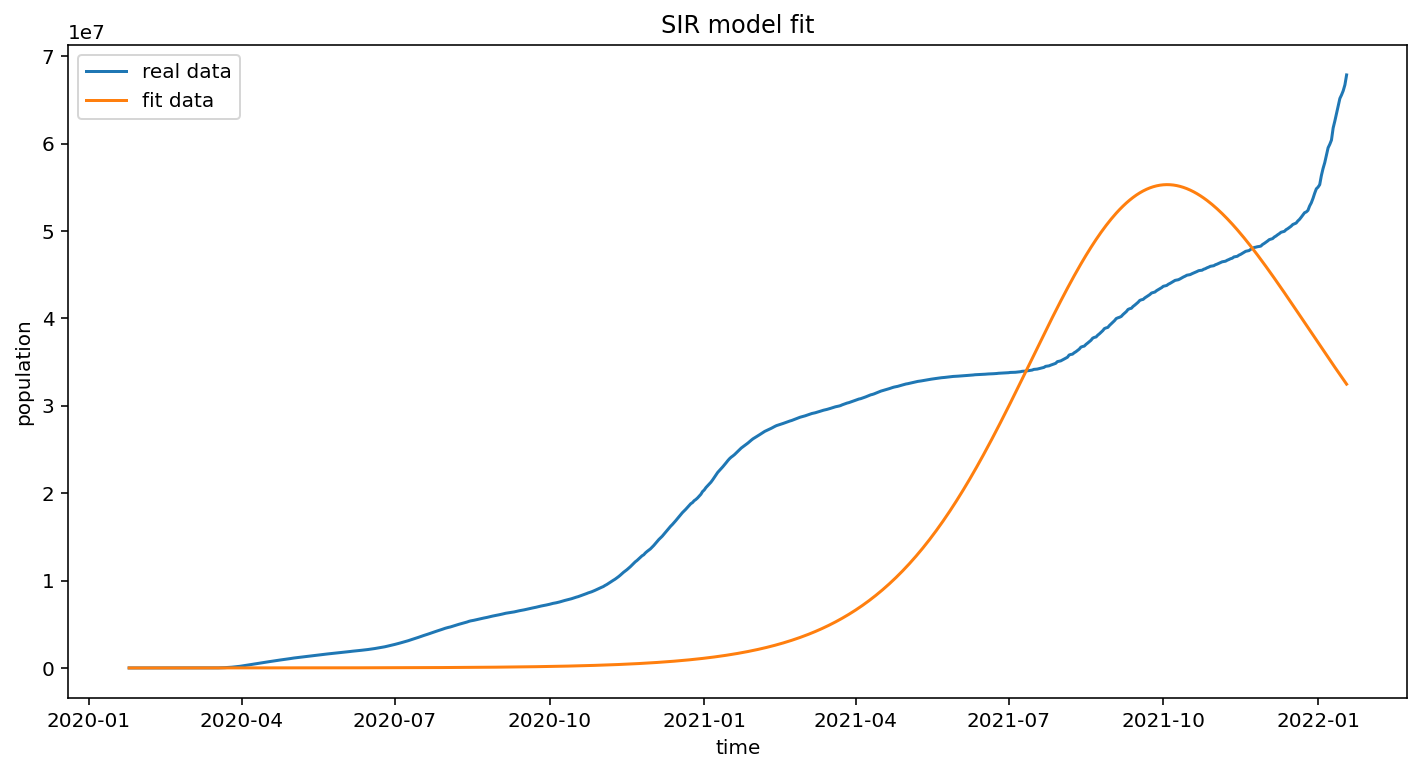

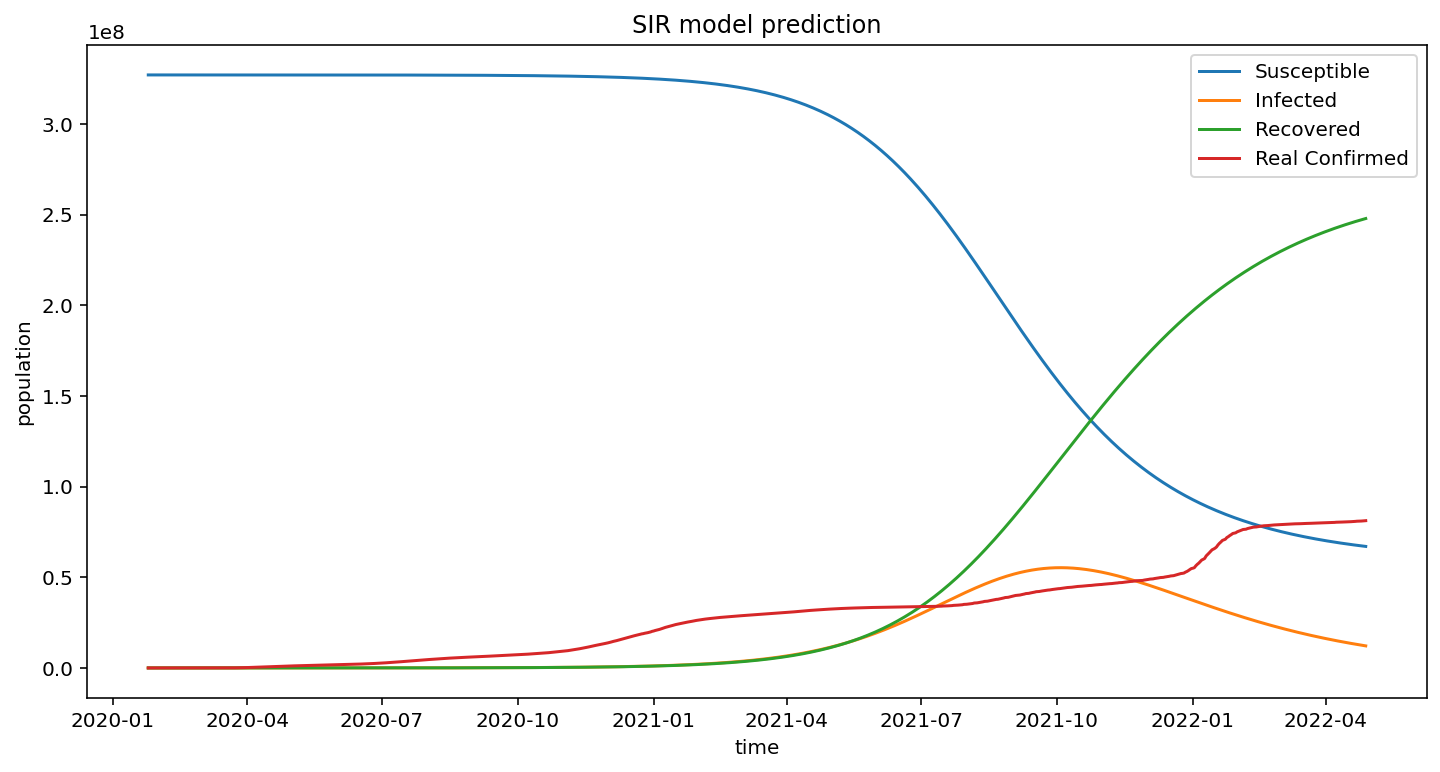


Average Prediction Error of SIR: 65.94244399181021%


#####################################################################
#####               Country: US  Model: SEIR                     
#####################################################################


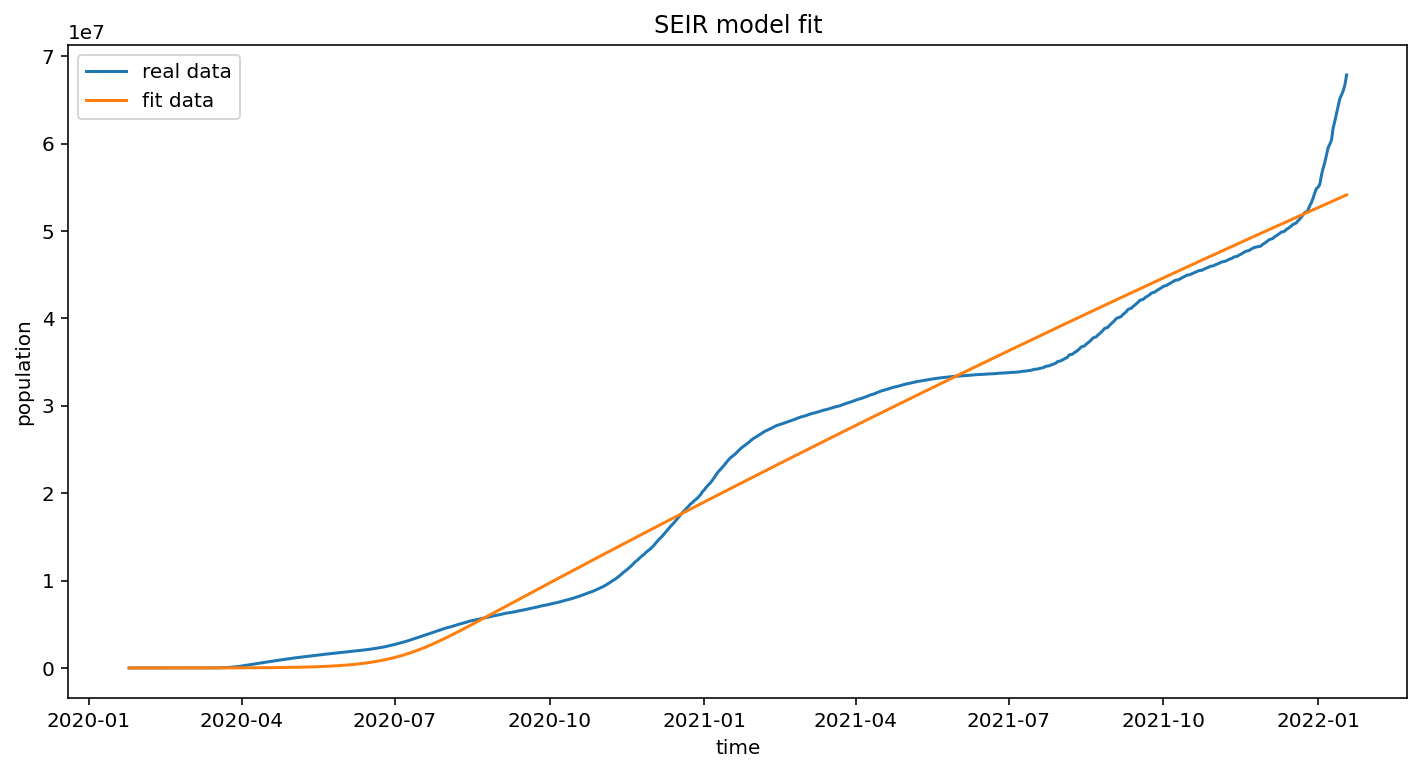

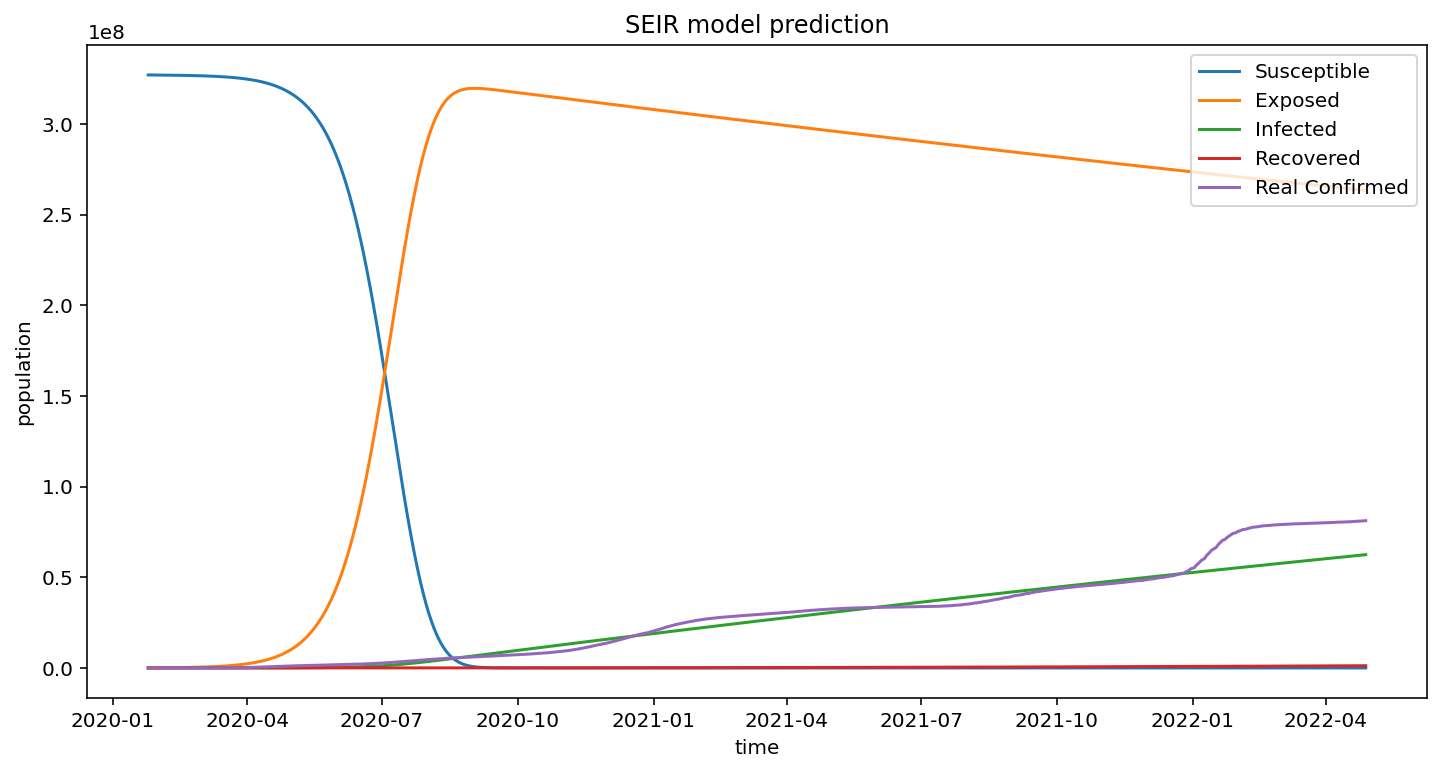


Average Prediction Error of SEIR: 19.878476813783216%


#####################################################################
#####               Country: US  Model: SEIRD                     
#####################################################################


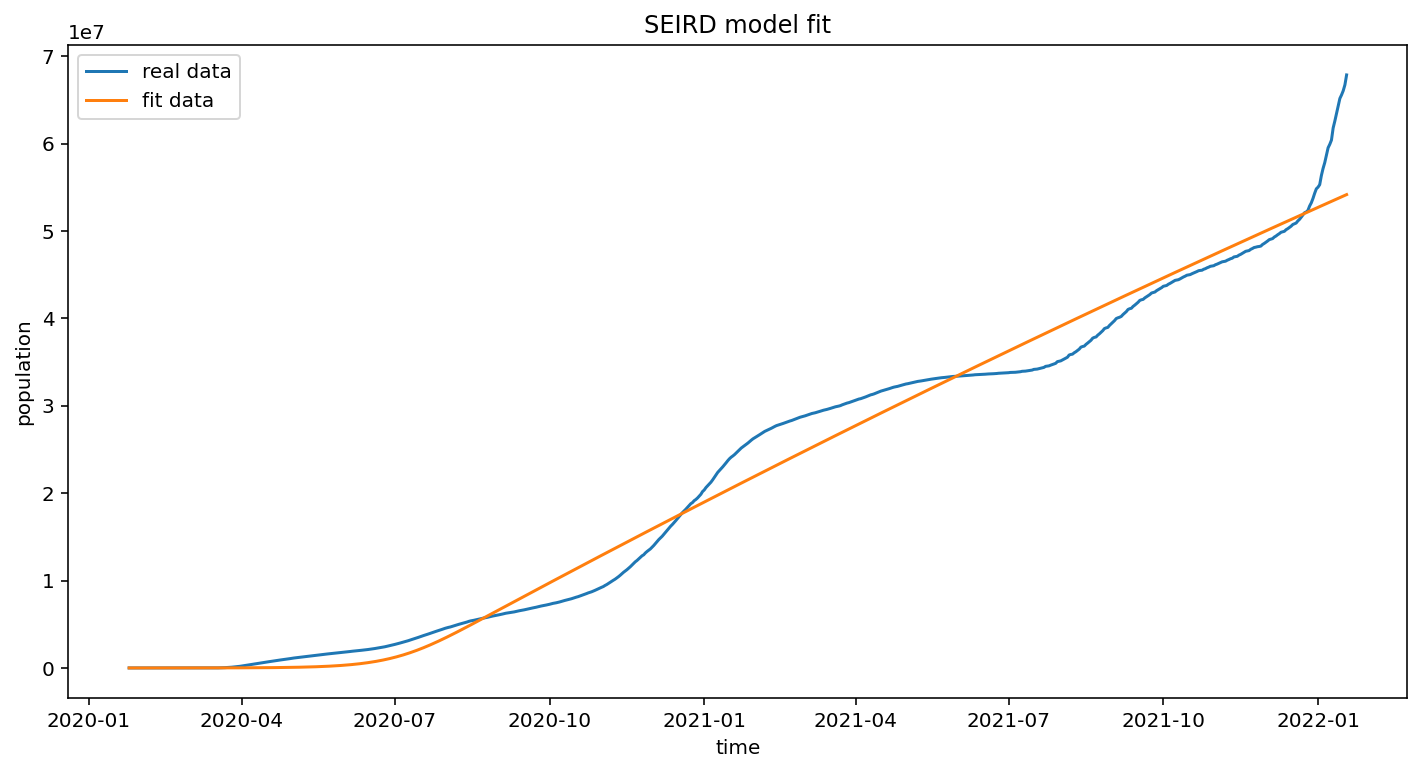

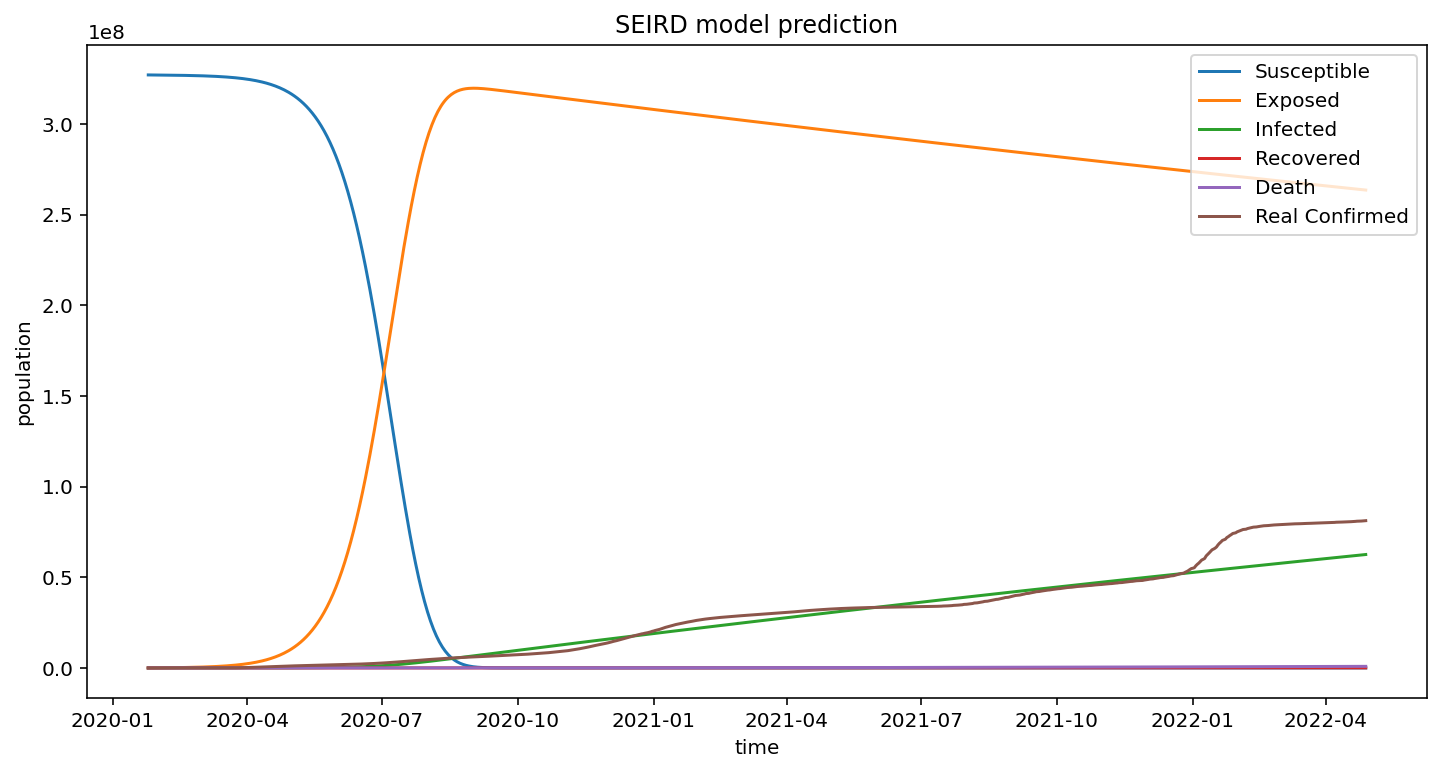


Average Prediction Error of SEIRD: 19.82870181822331%


#####################################################################


In [30]:
best_init_param_SIR = [0.7, 0.02, 0.01, 0.01, 0.01]
best_init_param_SEIR = [0.7, 0.04, 0.4, 0.01, 0.01]
best_init_param_SEIRD = [1.0, 0.01, 0.1, 0.7, 0.08]

# Experiment
test_model("US")

From the experiment results, it's obvious that the SEIRD has the best performance among these models and SIR is the worst model. The comparison of three models' average prediction error is shown in below table.

| **Model** |SIR |SEIR|SEIRD|
| :---------------------: | :---: | :---: | :---: |
| **Average Error (%)** |     65.94|     19.88 |     19.83|

Such results is easy to understand because SEIRD model is closest to the real situation among the three models. While the SIR model even cannot fit the known data very well, so the poor performance on the prediction duration is reasonable. 

However, even the SERID model cannot predict the future trends with complete accuracy, One of the main reasons is the new coronavirus is still in constant mutation, and the infectivity of different mutated virus subtypes is also changing. For example, since the emergence of the Omicron mutation, the infectivity of the virus has increased significantly, resulting in an accelerated growth in the number of confirmed cases, making the our model generated by fitting previous data unable to predict the its expanding trend accurately.



## 3. Conclusions

We notice obvious decrease in the average prediction error by comparing three models. Thus, we conclude that using SEIRD model to simulate COVID\-19 is a credible approach. Although there are many factors which might influence the prediction accuracy, through trade\-off between prediction accuracy and computation time, we believe using SEIRD model is a good choice.


## 4. References

\[1\] World Health Organization. \(n.d.\). Coronavirus disease \(covid\-19\): How is it transmitted? World Health Organization. Retrieved April 29, 2022, from https://www.who.int/news\-room/questions\-and\-answers/item/coronavirus\-disease\-covid\-19\-how\-is\-it\-transmitted 

\[2\] Tolles J, Luong T. Modeling Epidemics With Compartmental Models. JAMA. 2020;323\(24\):2515–2516. doi:10.1001/jama.2020.8420

\[3\] Harko T, Lobo FS, Mak MK \(2014\). "Exact analytical solutions of the Susceptible\-Infected\-Recovered \(SIR\) epidemic model and of the SIR model with equal death and birth rates". Applied Mathematics and Computation. 236: 184–194. arXiv:1403.2160. Bibcode:2014arXiv1403.2160H. doi:10.1016/j.amc.2014.03.030. S2CID 14509477

\[4\] Beckley R, Weatherspoon C, Alexander M, Chandler M, Johnson A, Bhatt GS \(2013\). "Modeling epidemics with differential equations" \(PDF\). Tennessee State University Internal Report. Retrieved July 19, 2020.

\[5\] Kröger M, Schlickeiser R \(2020\). "Analytical solution of the SIR\-model for the temporal evolution of epidemics. Part A: Time\-independent reproduction factor". Journal of Physics A. 53 \(50\): 505601. Bibcode:2020JPhA...53X5601K. doi:10.1088/1751\-8121/abc65d. S2CID 225555567.

\[6\] Schlickeiser R, Kröger M \(2021\). "Analytical solution of the SIR\-model for the temporal evolution of epidemics. Part B: Semi\-time case". Journal of Physics A. 54 \(17\): 175601. Bibcode:2021JPhA...54X5601S. doi:10.1088/1751\-8121/abed66.

\[7\] Real Python. \(2022, March 30\). Python GUI programming with Tkinter. Real Python. Retrieved April 29, 2022, from https://realpython.com/python\-gui\-tkinter/ 

\[8\] Moein, S., Nickaeen, N., Roointan, A. et al. Inefficiency of SIR models in forecasting COVID\-19 epidemic: a case study of Isfahan. Sci Rep 11, 4725 \(2021\). [https://doi.org/10.1038/s41598\-021\-84055\-6](https://doi.org/10.1038/s41598-021-84055-6).

\[9\] J. Ge, L. Zhang, Z. Chen, G. Chen and J. Peng, "Simulation Analysis of Epidemic Trend for COVID\-19 Based on SEIRS Model," 2020 IEEE 19th International Conference on Cognitive Informatics & Cognitive Computing \(ICCI\*CC\), 2020, pp. 158\-161, doi: 10.1109/ICCICC50026.2020.9450226.

\[10\] A. Sedaghat, S. Band, A. Mosavi and L. Nadai, "Predicting COVID\-19 \(Coronavirus Disease\) Outbreak Dynamics Using SIR\-based Models: Comparative Analysis of SIRD and Weibull\-SIRD," 2020 IEEE 3rd International Conference and Workshop in Óbuda on Electrical and Power Engineering \(CANDO\-EPE\), 2020, pp. 000283\-000288, doi: 10.1109/CANDO\-EPE51100.2020.9337791.

\[11\] N. Darapaneni et al., "Coronavirus Outburst Prediction in India using SEIRD, Logistic Regression and ARIMA Model," 2020 11th IEEE Annual Ubiquitous Computing, Electronics & Mobile Communication Conference \(UEMCON\), 2020, pp. 0649\-0655, doi: 10.1109/UEMCON51285.2020.9298097.

\[12\] K. Joshi and Y. Prasad, "An Improved ISEIRD Model for COVID\-19 Trend Simulations," 2021 IEEE 2nd International Conference on Smart Technologies for Power, Energy and Control \(STPEC\), 2021, pp. 1\-5, doi: 10.1109/STPEC52385.2021.9718677.

\[13\] Froese, H. \(2020, April 22\). Infectious disease modelling: Beyond the basic sir model. Medium. Retrieved April 29, 2022, from https://towardsdatascience.com/infectious\-disease\-modelling\-beyond\-the\-basic\-sir\-model\-216369c584c4 

